In [1]:
import time

# starting time
start = time.time()

In [2]:
import ReplayBuffer
import TD3
import gym 
import json
import Normalizer
import numpy as np
import tensorflow as tf
import keras
import os
import pickle

print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.2.0
Found GPU at: /device:GPU:0


In [3]:
REF_EXPERIMENT = '2_epoch_fetch_reach' 

In [4]:
ROOT = '.'
FOLDER_EXPORT_WEIGHTS = os.path.join(ROOT, REF_EXPERIMENT, 'weights')
FOLDER_EXPORT_RESULTS = os.path.join(ROOT, REF_EXPERIMENT, 'results')
FOLDER_EXPORT_NORMALIZERS = os.path.join(ROOT, REF_EXPERIMENT, 'normalizers')

os.makedirs(FOLDER_EXPORT_RESULTS)
os.makedirs(FOLDER_EXPORT_WEIGHTS)
os.makedirs(FOLDER_EXPORT_NORMALIZERS)

In [5]:
ENV_NAME = 'FetchReach-v1'
RND_SEED = 20210122

POLICY_NOISE = 0.2
NOISE_CLIP = 0.5
DISCOUNT = 0.99
TAU = 0.005
POLICY_FREQ = 2

EXPLORATION_NOISE = 0.1

CLIP_RANGE_OBS_GOAL = 5     # used in goal and obs normalizers

In [6]:
#set random seed 
tf.random.set_seed(RND_SEED)
np.random.seed(RND_SEED)

env = gym.make(ENV_NAME)
env.seed(RND_SEED)

[20210122]

In [7]:
# Training parameters
START_TIMESTEPS = 25e3

NUMBER_EPOCHS = 2
NUMBER_CYCLES = 50
NUMER_EPISODES = 16

TIMESTEPS_IN_EPISODE = env._max_episode_steps #50 
NUMBER_OPTIMIZATION_STEPS = 40
BATCH_SIZE = 128

In [8]:
observation_dim = env.observation_space['observation'].shape[0]
goal_dim = env.observation_space['desired_goal'].shape[0]

state_dim = observation_dim + goal_dim
action_dim = env.action_space.shape[0] 
max_value_action = float(env.action_space.high[0])

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_value_action": max_value_action,
    "discount": DISCOUNT,
    "tau": TAU,
    "policy_noise": POLICY_NOISE * max_value_action,
    "noise_clip": NOISE_CLIP * max_value_action,
    "policy_freq": POLICY_FREQ,
}

policy = TD3.TD3(**kwargs)
replay_buffer = ReplayBuffer.ReplayBuffer(state_dim, action_dim)

In [9]:
# normalizers used for observations and goals
obs_normalizer = Normalizer.normalizer(size=observation_dim, default_clip_range=CLIP_RANGE_OBS_GOAL)
goal_normalizer = Normalizer.normalizer(size=goal_dim, default_clip_range=CLIP_RANGE_OBS_GOAL)

In [10]:
def choose_action(state, noise=True):
    action_policy = policy.pi(np.array(state))
    if noise:
        noise = np.random.normal(0,  max_value_action * EXPLORATION_NOISE , size=action_dim)
        action = action_policy + noise 
        action = tf.clip_by_value(action, clip_value_min=-max_value_action, clip_value_max=max_value_action)
        action = tf.reshape(action, [action_dim])
        action = action.numpy()
    else:
        action = tf.reshape(action_policy, [action_dim])
    return action

In [11]:
def split_obs(obs_dict):    
    # split obs dictionary
    obs = obs_dict['observation']
    achieved_goal = obs_dict['achieved_goal']
    goal = obs_dict['desired_goal']
    return obs, achieved_goal, goal

def build_state(obs, goal):
    return np.concatenate((obs, goal))

def split_state(state):
    if len(state) != observation_dim + goal_dim:
        print("Error")
        return None
    obs = state[:observation_dim]
    goal = state[observation_dim:]
    
    return obs, goal

def normalize(obs, goal):
    obs_norm = obs_normalizer.normalize(obs)
    goal_norm = goal_normalizer.normalize(goal)
    return obs_norm, goal_norm

def update_normalizers(obs_history, goal_history):
    obs_his = np.array(obs_history)
    goal_his = np.array(goal_history)
    
    obs_normalizer.update(obs_his)
    goal_normalizer.update(goal_his)

    obs_normalizer.recompute_stats()
    goal_normalizer.recompute_stats()

def preprocess_state(state):
    obs, goal = split_state(state)
    obs_norm, goal_norm = normalize(obs, goal)
    state_norm = build_state(obs_norm, goal_norm)
    #print("norm=" + str(state_norm))
    return state_norm

In [12]:
def eval_policy(policy, env_name, seed, eval_episodes=10):
    eval_env = gym.make(env_name)
    eval_env.seed(seed + 100)

    total_success_rate = []
    for _ in range(eval_episodes):
        per_success_rate = []
        obs_dict, done = eval_env.reset(), False
        obs, achieved_goal, g = split_obs(obs_dict)
        for _ in range(eval_env._max_episode_steps):
            obs_norm, goal_norm = normalize(obs, g)
            state_norm = build_state(obs_norm, goal_norm)
            action = choose_action(state_norm, noise=False)

            observation_new, r, done, info = eval_env.step(action)
            obs = observation_new['observation']
            g = observation_new['desired_goal']
            per_success_rate.append(info['is_success'])
            #print(r)
            if done:
                break
        total_success_rate.append(per_success_rate)

    total_success_rate = np.array(total_success_rate)
    local_success_rate = np.mean(total_success_rate)

    print("--------------------------------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {local_success_rate*100:.2f}% success rate")
    print("--------------------------------------------------------------")
    return local_success_rate

In [13]:
# HER
def get_new_goals(step, current_episode, k=4):
    # get k indexes chosen randomly from current step to the end
    her_idxs = np.random.randint(step, len(current_episode), k)

    new_goals = []
    for idx in her_idxs:
        obs, ag, g, action, obs_next, ag_next, reward, done_f = current_episode[idx]
        new_goals.append(ag_next)
    return new_goals

In [14]:
history = {}
history['epoch'] = []
history['evaluation'] = []

#  Evaluate untrained policy
history['epoch'].append(0)
history['evaluation'].append(eval_policy(policy, ENV_NAME, RND_SEED))

--------------------------------------------------------------
Evaluation over 10 episodes: 0.00% success rate
--------------------------------------------------------------


In [15]:

t = 0   #total steps performed
for epoch in range(1, NUMBER_EPOCHS+1):
    print(f"Running : {epoch}° epoch ... ")
    for cycle in range(NUMBER_CYCLES):
        print(f"Epoch: {epoch}     Running: {cycle}° cycle [{str('#'*cycle)} {str(' '*(NUMBER_CYCLES-cycle))}]")
        for episode in range(NUMER_EPISODES):
            # used to perform HER
            current_episode = []
            
            # used to update normalizers
            obs_history = []
            goal_history = []
            
            obs_dict, done = env.reset(), False
            for step in range(TIMESTEPS_IN_EPISODE):
                t += 1

                obs, achieved_goal, goal = split_obs(obs_dict)
                obs_history.append(obs.copy())
                goal_history.append(goal.copy())

                if t < START_TIMESTEPS:
                    action = env.action_space.sample()  #chose random action
                else:
                    obs_norm, goal_norm = normalize(obs, goal)
                    state_norm = build_state(obs_norm, goal_norm)
                    action = choose_action(state_norm)

                obs_dict_next, reward, done, _ = env.step(action) 
                obs_next, ag_next, goal = split_obs(obs_dict_next)
                done_f= float(done) if step < env._max_episode_steps else 0
                            
                # save current episode
                current_episode.append([obs.copy(), achieved_goal.copy(), goal.copy(),
                                        action.copy(),
                                        obs_next.copy(), ag_next.copy(),
                                        reward, done_f])

                obs_dict = obs_dict_next

                if done==1:
                    break

            obs, achieved_goal, goal = split_obs(obs_dict)
            obs_history.append(obs.copy())

            for idx in range(len(current_episode)):
                #store standard transition
                obs, ag, g, action, obs_next, ag_next, reward, done_f = current_episode[idx]
                state = build_state(obs, goal)
                next_state = build_state(obs_next, goal)
                replay_buffer.add(state, action, next_state, reward, done_f)

                #HER
                new_goals = get_new_goals(idx, current_episode)
                for new_goal in new_goals:
                    goal_history.append(new_goal.copy())

                    her_obs = obs 
                    her_ag = ag 
                    her_g = new_goal
                    her_action = action 
                    her_obs_next = obs_next 
                    her_ag_next = ag_next 
                    her_reward = env.compute_reward(her_ag_next, her_g, None)
                    her_done_f = 1.0 if her_reward == 0 else 0.0

                    her_state = build_state(her_obs, her_g)
                    her_next_state = build_state(her_obs_next, her_g)
                    replay_buffer.add(her_state, her_action, her_next_state, her_reward, her_done_f)

            #update normalizers
            update_normalizers(obs_history, goal_history)

            for training_step in range(NUMBER_OPTIMIZATION_STEPS):
                policy.train(replay_buffer, batch_size=BATCH_SIZE, func_preprocess_state=preprocess_state)

    # evaluation at the end of each epoch
    success_rate = eval_policy(policy, ENV_NAME, RND_SEED)
    history['epoch'].append(epoch)
    history['evaluation'].append(success_rate)

    # save model
    prefix = str(epoch) +"_epoch_" + str(success_rate)
    
    #SAVE WEIGHTS
    out_path = os.path.join(FOLDER_EXPORT_WEIGHTS, prefix+"__SUCCESS_RATE")
    os.makedirs(out_path)
    policy.save_weights_networks(out_path)

    #SAVE NORMALIZERS
    out_path = os.path.join(FOLDER_EXPORT_NORMALIZERS, prefix+"__obs_normalizer")
    filehandler = open(out_path, 'wb') 
    pickle.dump(obs_normalizer, filehandler)
    filehandler.close()
    
    out_path = os.path.join(FOLDER_EXPORT_NORMALIZERS, prefix+"__goal_normalizer")
    filehandler = open(out_path, 'wb') 
    pickle.dump(goal_normalizer, filehandler)
    filehandler.close()

    print("Saved current model")

Running : 1° epoch ... 
Epoch: 1     Running: 0° cycle [                                                   ]
Epoch: 1     Running: 1° cycle [#                                                  ]
Epoch: 1     Running: 2° cycle [##                                                 ]
Epoch: 1     Running: 3° cycle [###                                                ]
Epoch: 1     Running: 4° cycle [####                                               ]
Epoch: 1     Running: 5° cycle [#####                                              ]
Epoch: 1     Running: 6° cycle [######                                             ]
Epoch: 1     Running: 7° cycle [#######                                            ]
Epoch: 1     Running: 8° cycle [########                                           ]
Epoch: 1     Running: 9° cycle [#########                                          ]
Epoch: 1     Running: 10° cycle [##########                                         ]
Epoch: 1     Running: 11° cycle [#######

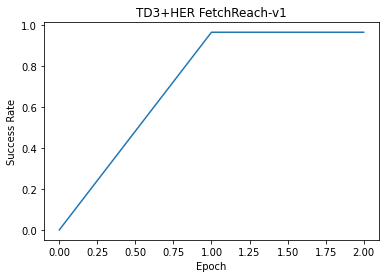

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(history['epoch'], history['evaluation'])
plt.title('TD3+HER '+ ENV_NAME)
plt.ylabel('Success Rate')
plt.xlabel('Epoch')
plt.savefig(os.path.join(FOLDER_EXPORT_RESULTS, "history.png"))

In [17]:
# end time
end = time.time()
elapsed = end - start
# total time taken
print(f"Runtime of the program is {elapsed}")

Runtime of the program is 2046.8710136413574


In [18]:
filename = os.path.join(FOLDER_EXPORT_RESULTS, "time.info")
f_out = open(filename, 'w')
f_out.write(str(elapsed))
f_out.close()